<a href="https://www.kaggle.com/code/minhbtnguyen/classifying-flower-species-with-deep-learning?scriptVersionId=119505036" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying Flower Species: A Deep Learning Approach With Keras
- **Date**: 2/4/2023.
- **Author**: [Minh T. Nguyen](https://www.kaggle.com/minhbtnguyen).
- **Dataset**: [UCI Iris Species](https://www.kaggle.com/datasets/uciml/iris).
- **Task**: Classification.
- **Framework**: Keras, Sklearn.

**Note**: *I use Kaggle to learn from others and practice my skills so any comment or suggestion is welcome!* 

![](https://www.embedded-robotics.com/wp-content/uploads/2022/01/Iris-Dataset-Classification.png)

In [1]:
# import library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import copy

# import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [2]:
# set random seed for same results when reproducing the notebook
np.random.seed(0)

# 1. Import Dataset

In [3]:
# connect with Kaggle directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


In [4]:
# import dataset
df = pd.read_csv("/kaggle/input/iris/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# check the shape of the dataset
print(df.shape)

(150, 6)


**Note**: The shape tells use that there are 150 rows (samples) and 6 columns.

# 2. Data Visualization & Analysis

**Note**: Shape of the normal distribution (Gaussian distribution)

![](https://cdn.scribbr.com/wp-content/uploads/2020/10/standard-normal-distribution-1024x633.png)

**Note**: Let's plot the features (columns) of the dataset and see how they shape compared to the Gaussian distribution.

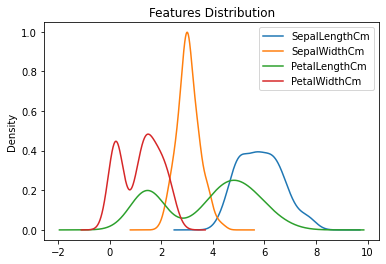

In [6]:
# plot the distribution for all 4 columns
plt.title("Features Distribution")
df['SepalLengthCm'].plot(kind='kde')
df['SepalWidthCm'].plot(kind='kde')
df['PetalLengthCm'].plot(kind='kde')
df['PetalWidthCm'].plot(kind='kde')
plt.legend()
plt.show()

**Note**: We can see that all 4 features "behaves" similar to the Gaussian Distribution with different mean and standard deviation. Although UCI claims that Iris Dataset is a real dataset, this plot add an additional confirmation as most of the dataset has Gaussian distribution. The data points near the mean are more frequent in occurrent that the data far from the mean.

*[Reference](https://www.investopedia.com/terms/n/normaldistribution.asp#:~:text=Normal%20distribution%2C%20also%20known%20as,as%20a%20%22bell%20curve%22.).*

# 3. Data Processing
**Note**: There are ways to process raw data that suitable for types of data and how they are structure such as check NaN, feature engineering, normalization, data imputation,... However, for this dataset, I will do the following steps: 
- Check NaN.
- Normalize the dataset
- Split it into training and testing set.

## 3.1. Check Not-a-Number (NaN) Data

In [7]:
# Examine and replace missing values 
print(df.isnull().values.any())

False


## 3.2. Normalize Dataset
- Convert the label from text-based to number-based.
- Split the data in to input features (X) and output label (y).
- As Id is just an column for identification, we will not include it in the input features (X).

In [8]:
# check unique labels
print(df["Species"].unique())

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [9]:
# convert text-based to number-base label for output labels
y = []

for species in df["Species"]:
    if species == "Iris-setosa":
        y.append(0)
    elif species == "Iris-versicolor":
        y.append(1)
    else:
        y.append(2)

In [10]:
# get input features X 
X = df[list(df.columns[1:-1])]
print(X.shape)

(150, 4)


In [11]:
# partition into training/test/validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# convert each label to one-hot-encoder
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
# [0 1 0] == ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'], meaning the label is 'Iris-versicolor'
print(y_train[0])

[0. 1. 0.]


In [14]:
# normalized training data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# normalized testing data
X_test -= mean
X_test /= std

**Note**: that we normalize the test data based on the training data. We don't want to normalized the test data based on the training distribution as we want to test the model on the same distribution of what we train.


In [15]:
# check shape of training data
print(X_train.shape)
print(y_train.shape)

(105, 4)
(105, 3)


In [16]:
# check shape of testing data
print(X_test.shape)
print(y_test.shape)

(45, 4)
(45, 3)


# 4. Modeling
**Note**: As the dataset is a fairly small dataset, we only need a small model. We can use a larger model, however, it will be a waste of computing power and risk to the large model to learn unwanted patterns.

In [17]:
def build_model():
    """Build a deep learning model with 3 layers
    while initialize optimizer, loss function, and metrics
    """
    # contruct model
    model = keras.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(3, activation="sigmoid"),
    ])
    
    # initialize optimizer, loss function, and performance metrics
    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# 5. K-Fold Validation
**Note**: Right now, we don't know how well is our model's structure as well as the number of epochs to train (if we train the model too much, then the model will overfit!). For the larger dataset, we can simply take a portion of the traininig dataset as validation dataset and check the performance prior to training the entire training data. However, since the dataset is small, K-Fold validation will be a better choice. The image below showed how K-Fold validation works.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

[Reference](https://scikit-learn.org/stable/modules/cross_validation.html).

In [18]:
num_epochs = 500
k = 4
num_val_samples = len(X_train) // k
all_accuracy_history = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    # split 1 fold for validation
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    # get the rest of 3 folds for training
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    # build model
    model = build_model()
    
    # train model on training dataset
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        epochs=num_epochs, 
                        batch_size=16,
                        validation_data=(val_data, val_targets),
                        verbose=0) # verbose == training without print out every training epoch
    
    # log model performance
    accuracy_history = history.history["val_accuracy"]
    all_accuracy_history.append(accuracy_history)

Processing fold #0


2023-02-17 22:15:15.979690: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-17 22:15:16.112755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Processing fold #1
Processing fold #2
Processing fold #3


In [19]:
# check shape: 4 accuracies result (each fold) x 500 epochs
print(np.array(all_accuracy_history).shape)

(4, 500)


Note: Let's convert (4 x 500) matrix to a list of size 500 so we can plot later by calculate the average of 4 (folds) accuracy at each epoch

In [20]:
average_accurary_history = []

# go thru 500 epochs
for i in range(num_epochs):
    temp = []
    
    # go thru each fold and get the accuracy at that epoch
    for x in all_accuracy_history:
        temp.append(x[i])
    
    # calculate the mean accuracy for that epoch
    temp = np.mean(temp)
    
    # store in the average accuracy log
    average_accurary_history.append(temp)

In [21]:
# check shape
print(len(average_accurary_history))

500


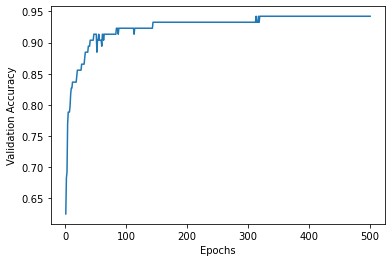

In [22]:
# plot validation score from history
plt.plot(range(1, len(average_accurary_history) + 1), average_accurary_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

**Analysis**: Here we can see that the model stopped improving after ~250 epochs. So let's retrain the model on a full training set for 250 epochs. 

**Note**: The validation accuracy is pretty good (~95%), so we don't have to change the model's architecture.

# 6. Train Model on Full Training Dataset

In [23]:
# create model
model = build_model()

# retrain model on full dataset 
model.fit(X_train, 
          y_train,
          epochs=250, 
          batch_size=16,
          verbose=0)

In [24]:
# test on the testing dataset
results = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.1922 - accuracy: 0.9778


**Analysis**: We can see that the loss is low and the accuracy of the model is high in the test dataset. Because it is higher than the validation accuracy, the model is not overfit!

# 7. Compare With Random Class
**Note**: What if you want to check how is our model perform compare to a random classifier?

In [25]:
# make a copy of label
y_test_copy = copy.copy(y_test)

# randomly shuffle it
np.random.shuffle(y_test_copy)

# check how many match we got after shuffle
hits_array = np.array(y_test) == np.array(y_test_copy)

# print out mean
print(hits_array.mean())

0.5555555555555556


**Note**: A random classifier is 56% accuracy only so our model perform way better!

# 8. Model "Deployment" Test
**Note**: What if you want to see how our model perform during a "deployment" process? Let's test it on a sample on the testing dataset

In [26]:
# make prediction on all test dataset
predictions = model.predict(X_test)

In [27]:
print(np.argmax(predictions[0]))
print(np.argmax(y_test[0]))

2
2


**Note**: The prediction and the label are matched!

![](https://images.unsplash.com/photo-1558256720-a8ceb13f335d?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80)